# 5. Model Insepction
Inspect models outputs using partial dependence plots (PDPs) and individual conditional expectation (ICE) plots

In [25]:
import sys
sys.path.insert(0, '..')

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchtuples as tt
from dill import load
from joblib import Parallel, delayed, parallel_config
from pycox.models import MTLR
from sklearn.inspection import (PartialDependenceDisplay, partial_dependence,
                                permutation_importance)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted
from sksurv.datasets import get_x_y
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from tqdm.auto import trange

from scjdsurv.config import BATCH_SIZE, SEED
from scjdsurv.model import load_parameters
from scjdsurv.nn import model_dict
from scjdsurv.preprocess import CatEncode

Import Data

In [26]:
# Import imputed training data
with open('mice/imputed_train', 'rb') as file:
    imputed_train = load(file)
    
# Import imputed test data
with open('mice/imputed_test', 'rb') as file:
    imputed_test = load(file)

# 5.1 Fit Models
## NMTLR
Some adjustments need to be made to sCJDSurvModel to allow explanation on encoded features rather than imputed_test. We take CatEncode step out and perform this prior to passing data to sCJDSurvModel.

In [27]:
class sCJDSurvModel:
    
    def __init__(self, model_name:str, device='cpu'):
        """Instantiate a single model in the sCJDSurv ensemble

        Args:
            model_name (str): Official model name
            device (str, optional): Device to train on. Defaults to 'cpu'.
        """
        self._estimator_type = 'regressor'
        self.model_name = model_name
        self.device = device
    
    def fit(self, params:dict, X:pd.DataFrame, y:np.array):
        """Fit a single sCJDSurv model

        Args:
            params (dict): Model parameters
            X (pd.DataFrame): Feature DataFrame
            y (np.array): Label array

        Returns:
            self: trained model
        """
        
        # Store given params in object
        self.params = params
        
        # Extract parameters
        lr = params['lr']
        # batch_size = params['batch_size']
        epochs = params['epochs']
        weight_decay = params['weight_decay']
        
        net_params = {}
            
        try:
            net_params.update({'dropout': params['dropout']})
        except:
            pass
        try:
            net_params.update({'hl1_nodes': params['hl1_nodes']})
        except:
            pass
        try:
            net_params.update({'hl2_nodes': params['hl2_nodes']})
        except:
            pass
        try:
            net_params.update({'hl3_nodes': params['hl3_nodes']})
        except:
            pass
        try:
            net_params.update({'hl4_nodes': params['hl4_nodes']})
        except:
            pass
        try:
            net_params.update({'hl5_nodes': params['hl5_nodes']})
        except:
            pass
        
        # Set random seeds
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        random.seed(SEED)
        
        #### PREPROCESSING ####
        
        # Standardize X
        self.ss = StandardScaler()
        X = self.ss.fit_transform(X).astype('float32')
        
        # Label Transforms
        num_durations = 100
        labtrans = MTLR.label_transform(num_durations, 'equidistant')
        get_target = lambda df: (df['duration_m'], df['status'])
        y_pycox = labtrans.fit_transform(*get_target(y))
        
        # Create neural net
        net = model_dict[self.model_name](
            X.shape[1],
            out_features=labtrans.out_features,
            **net_params
        )
        
        # Set optimizier
        optimizer = tt.optim.Adam(lr, weight_decay=weight_decay)
        
        # Set model
        self.model = MTLR(net, optimizer, duration_index=labtrans.cuts, device=self.device)
        
        # Train model
        log = self.model.fit(
            X,
            y_pycox,
            batch_size=BATCH_SIZE,
            epochs=epochs,
            verbose=False,
        )
        
        # Set fitted data
        self.X_ = X
        self.y_ = y
        
        return self
    
    def predict_surv_df(self, X:pd.DataFrame, sub:int=10) -> pd.DataFrame:
        """Predict survival function

        Args:
            X (pd.DataFrame): Feature DataFrame
            sub (int, optional): Number of 'sub' units in interpolation grid. Defaults to 10.

        Returns:
            pd.DataFrame: Predicted survival functions (n_timepoints, n_individuals)
        """
        
        # Check if fit has been called
        check_is_fitted(self)
        
        # Standardize X
        X = self.ss.transform(X).astype('float32')
        
        surv = self.model.interpolate(sub).predict_surv_df(X)
        
        return surv
    
    def predict(self, X:pd.DataFrame, sub=10) -> np.array:
        """Predict risk scores

        Args:
            X (pd.DataFrame): Feature DataFrame
            sub (int, optional): Number of 'sub' units in interpolation grid. Defaults to 10.

        Returns:
            np.array: Predicted risk scores (n_individuals)
        """
        
        surv = self.predict_surv_df(X, sub=sub)
        return 1-surv.mean(axis=0)
    
    def score(self, X, y):
        surv = self.predict_surv_df(X).T
        model_times = surv.columns
        
        # Find indices of event times of model that correspond to test times
        indices = np.where(
            np.logical_and(
                model_times > min(y['duration_m']),
                model_times < max(y['duration_m'])
            )
        )
        
        # Set estimator time window to all available timepoints
        times = model_times[indices]
        
        # Subset surv to times
        surv = surv[times]
        
        return -integrated_brier_score(
            self.y_,
            y,
            surv,
            times
        )

In [28]:
# Train chosen NMTLR model
model_name = '3 layers MLP, ReLU, BatchNorm, Dropout'

ensemble_parameters = load_parameters(f'./parameters/{model_name}.json')
    
def _fit_single_model(mice_i):
    # Get parameters
    params = ensemble_parameters.loc[mice_i]
    
    # Get X and y arrays
    X_train, y_train = get_x_y(imputed_train[mice_i], attr_labels=['status', 'duration_m'], pos_label=True, survival=True)
    
    # CatEncode X
    encoder = CatEncode(drop_dummy=True)
    encoder.fit(X_train)
    X_train = encoder.transform(X_train)
    
    # Fit model
    model = sCJDSurvModel(model_name)
    model.fit(params, X_train, y_train)
    
    return encoder, model    

with parallel_config(backend='loky', inner_max_num_threads=1):
    nmtlr_ensemble = Parallel(n_jobs=10)(delayed(_fit_single_model)(mice_i) for mice_i in range(10))

In [29]:
# NMTLR Sanity check

ibs = []

for mice_i in range(10):
    
    # Get encoder and model
    encoder, model = nmtlr_ensemble[mice_i][0], nmtlr_ensemble[mice_i][1]
    
    # Get X and y arrays
    X_test, y_test = get_x_y(imputed_test[mice_i], attr_labels=['status', 'duration_m'], pos_label=True, survival=True)
    
    # Encode X
    X_test = encoder.transform(X_test)
    
    ibs.append(model.score(X_test, y_test))

np.mean(ibs)

-0.07800543019413678

## CoxPH
Similarly, a small adjustment needs to be made to allow explanation on encoded features.

In [30]:
class CoxPHModel:
    def __init__(self):
        """Instantiate a CoxPHEnsemble ensemble"""
        
        self._estimator_type = 'regressor'
    
    def fit(self, X:pd.DataFrame, y:np.array):
        """Fit single CoxPH model

        Args:
            X (pd.DataFrame): Feature DataFrame
            y (np.array): Label array
        """
                    
        self.model = CoxPHSurvivalAnalysis()
        self.model.fit(X, y)
        
        self.X_ = X
        self.y_ = y
        
        return self

    def predict(self, X:pd.DataFrame) -> np.array:
        """Predict risk scores

        Args:
            X (pd.DataFrame): Feature DataFrame

        Returns:
            np.array: Predicted risk scores (n_individuals)
        """
        surv = self.model.predict_survival_function(X, return_array=True)
        model_times = self.model.unique_times_
        surv_df = pd.DataFrame(surv, columns=model_times).T
        return 1-surv_df.mean(axis=0)
    
    def score(self, X, y):
        
        surv = self.model.predict_survival_function(X, return_array=True)
        model_times = self.model.unique_times_
        surv = pd.DataFrame(surv, columns=model_times)
    
        # Find indices of event times of model that correspond to test times
        indices = np.where(
            np.logical_and(
                model_times > min(y['duration_m']),
                model_times < max(y['duration_m'])
            )
        )
        
        # Set estimator time window to all available timepoints
        times = model_times[indices]
        
        # Subset surv to times
        surv = surv[times]
        
        return -integrated_brier_score(
            self.y_,
            y,
            surv,
            times
        )

In [31]:
# Train CoxPH Model

def _fit_single_model(mice_i):

    # Get X and y arrays
    X_train, y_train = get_x_y(imputed_train[mice_i], attr_labels=['status', 'duration_m'], pos_label=True, survival=True)
    
    # CatEncode X
    encoder = CatEncode(drop_dummy=True)
    encoder.fit(X_train)
    X_train = encoder.transform(X_train)
    
    # Fit model
    model = CoxPHModel()
    model.fit(X_train, y_train)
    
    return encoder, model    

with parallel_config(backend='loky', inner_max_num_threads=1):
    coxph_ensemble = Parallel(n_jobs=10)(delayed(_fit_single_model)(mice_i) for mice_i in range(10))

In [32]:
# CoxPH Sanity check

ibs = []

for mice_i in range(10):
    
    # Get encoder and model
    encoder, model = coxph_ensemble[mice_i][0], coxph_ensemble[mice_i][1]
    
    # Get X and y arrays
    X_test, y_test = get_x_y(imputed_test[mice_i], attr_labels=['status', 'duration_m'], pos_label=True, survival=True)
    
    # Encode X
    X_test = encoder.transform(X_test)
    
    ibs.append(model.score(X_test, y_test))

np.mean(ibs)

-0.08265046337347434

## 5.2 Permutation Importance

NMTLR

In [33]:
def _explain_single_nmtlr_model(mice_i):
    
    # Get encoder and model
    encoder, model = nmtlr_ensemble[mice_i][0], nmtlr_ensemble[mice_i][1]
    
    # Get X and y arrays
    X_test, y_test = get_x_y(imputed_test[mice_i], attr_labels=['status', 'duration_m'], pos_label=True, survival=True)

    # Encode X
    X_test = encoder.transform(X_test)
    
    perm_imp = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=50,
        n_jobs=-1,
        random_state=SEED
    )

    return pd.Series(perm_imp.importances_mean, X_test.columns)

nmtlr_feat_imps = [_explain_single_nmtlr_model(mice_i) for mice_i in trange(10)]

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
# Permutation Feature Importances
nmtlr_feat_imps_result = pd.concat(nmtlr_feat_imps, axis=1).mean(axis=1).sort_values(ascending=False)
nmtlr_feat_imps_result = nmtlr_feat_imps_result.reset_index()
nmtlr_feat_imps_result = nmtlr_feat_imps_result.rename({0: 'feature_importance', 'index': 'feature'}, axis=1)

CoxPH

In [35]:
def _explain_single_coxph_model(mice_i):
    
    # Get encoder and model
    encoder, model = coxph_ensemble[mice_i][0], coxph_ensemble[mice_i][1]
    
    # Get X and y arrays
    X_test, y_test = get_x_y(imputed_test[mice_i], attr_labels=['status', 'duration_m'], pos_label=True, survival=True)

    # Encode X
    X_test = encoder.transform(X_test)
    
    perm_imp = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=50,
        n_jobs=-1,
        random_state=SEED
    )

    return pd.Series(perm_imp.importances_mean, X_test.columns)

coxph_feat_imps = [_explain_single_coxph_model(mice_i) for mice_i in trange(10)]

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
# Permutation Feature Importances
coxph_feat_imps_result = pd.concat(coxph_feat_imps, axis=1).mean(axis=1).sort_values(ascending=False)
coxph_feat_imps_result = coxph_feat_imps_result.reset_index()
coxph_feat_imps_result = coxph_feat_imps_result.rename({0: 'feature_importance', 'index': 'feature'}, axis=1)

Plot

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

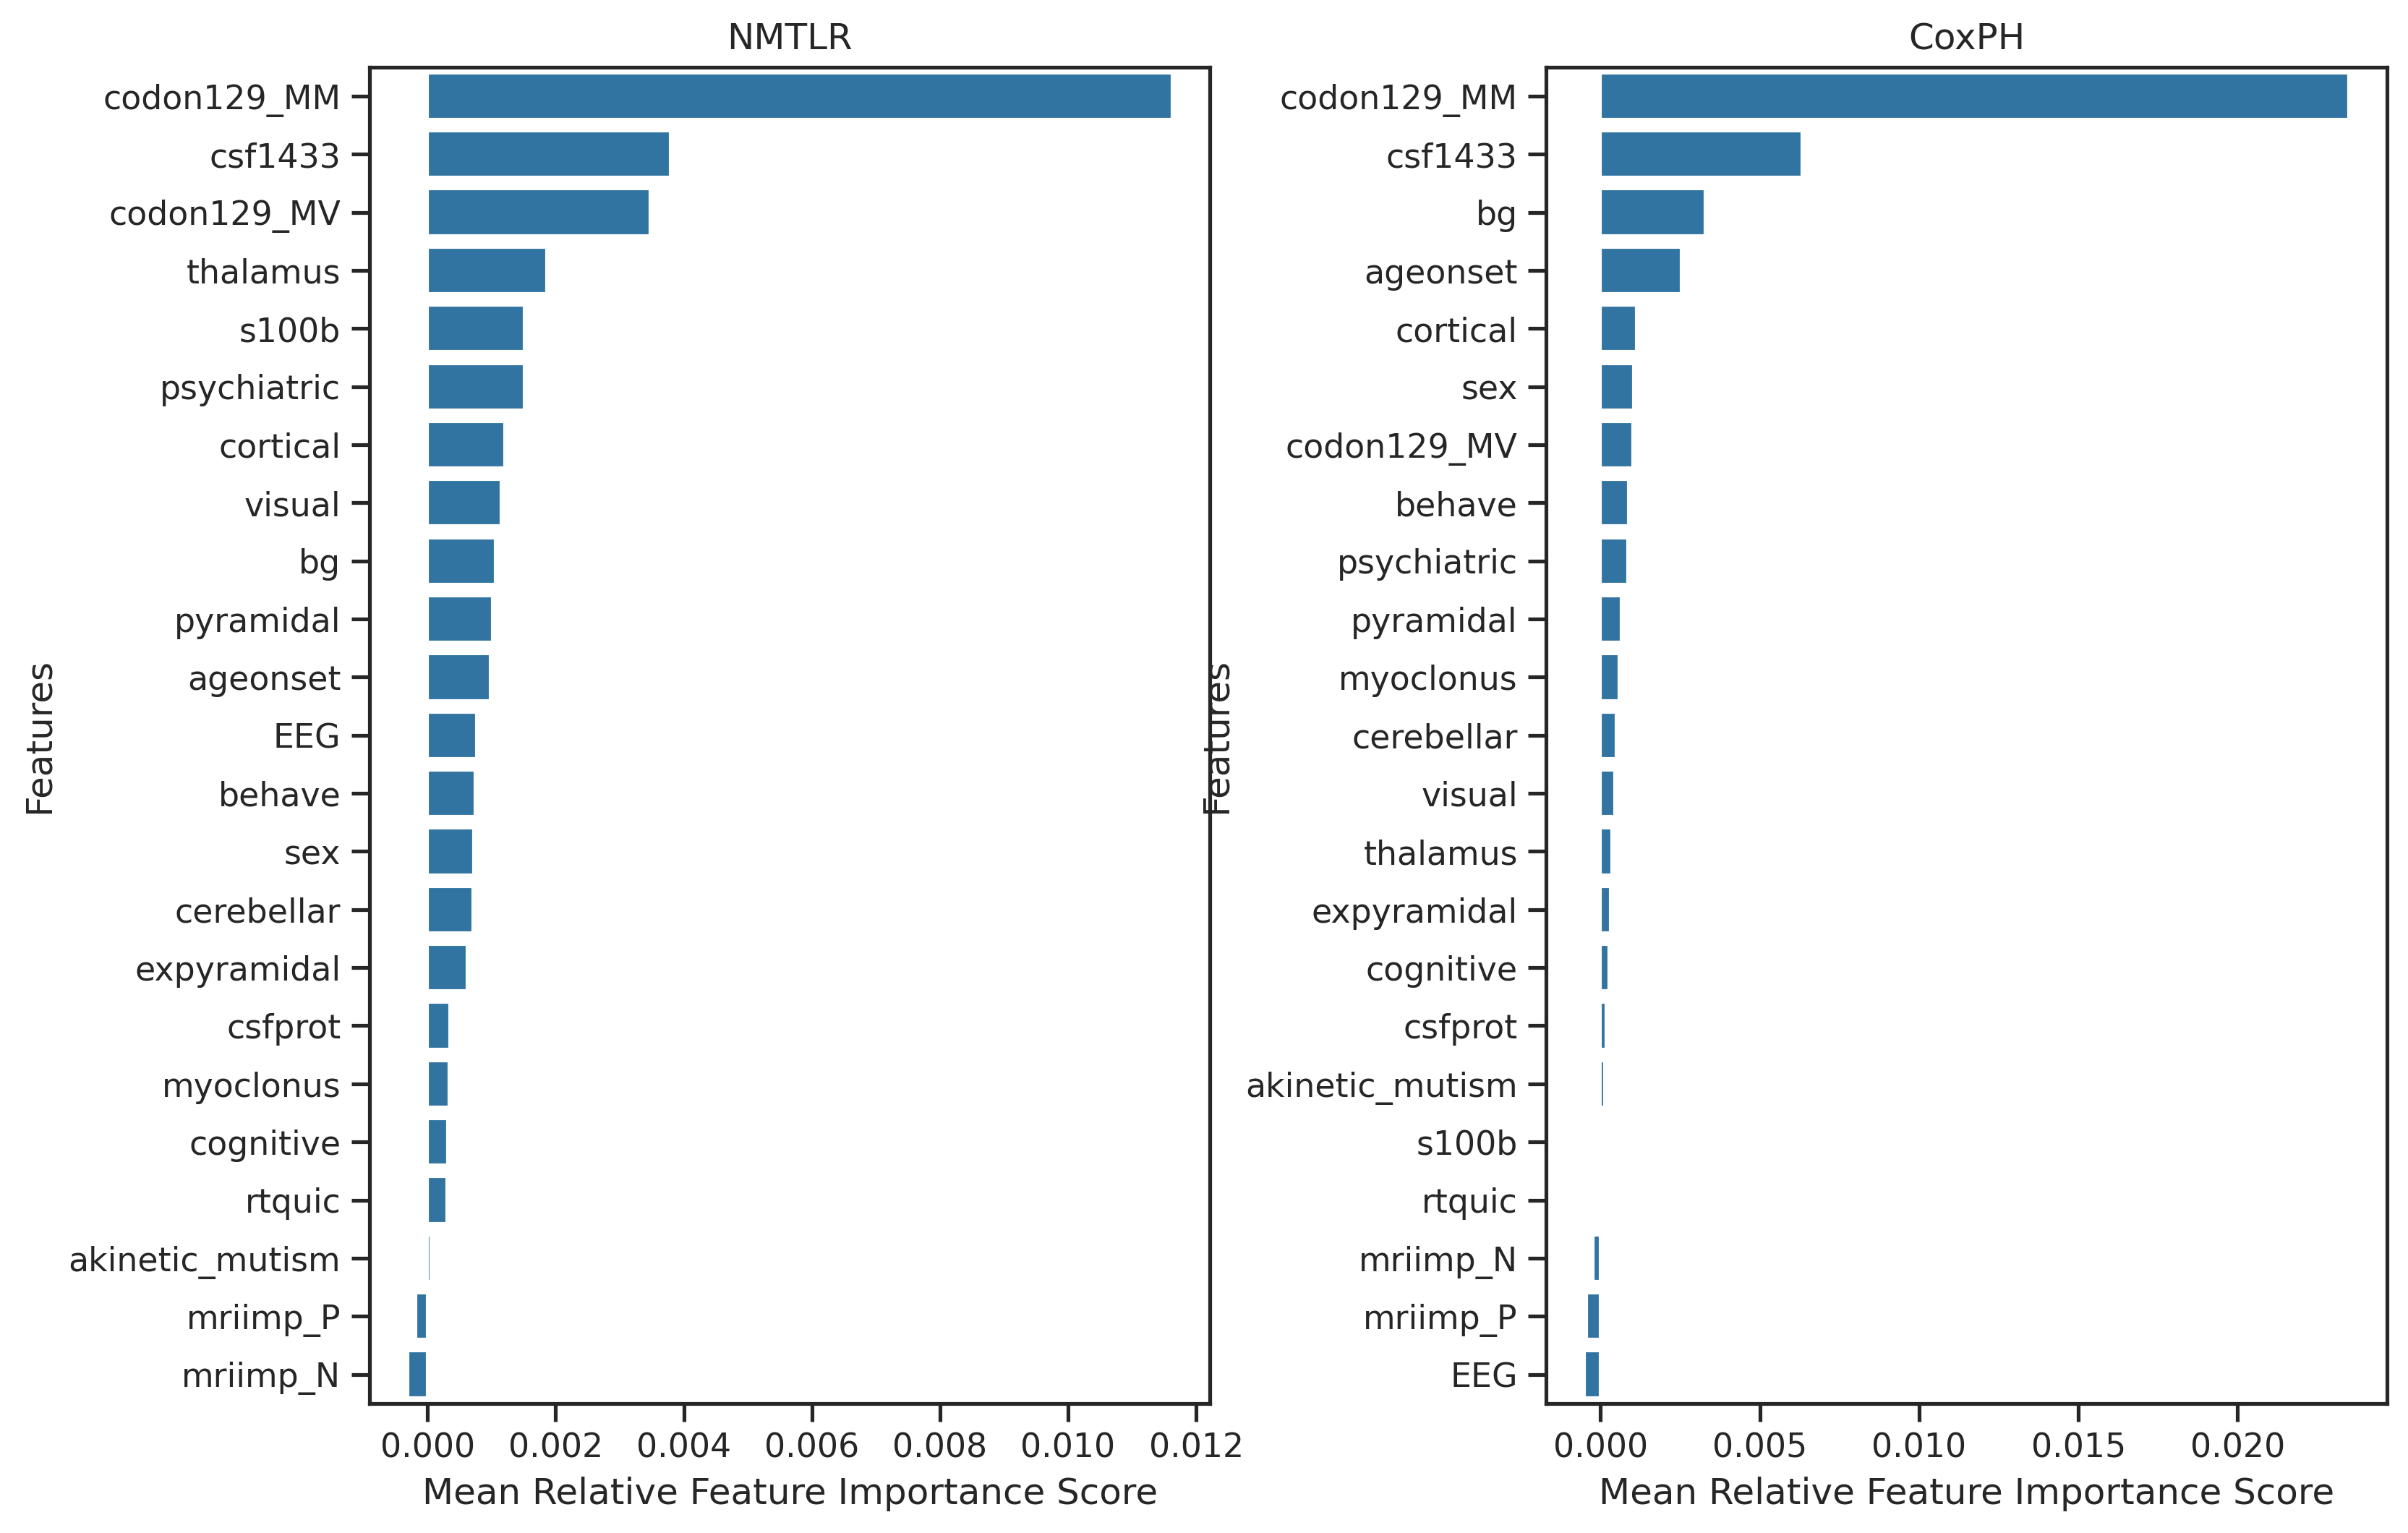

In [37]:
# Configure Subplots
fig, axes = plt.subplots(1, 2, figsize=(12,8), dpi=300)
sns.set_theme(
    style='darkgrid',
    font='Arial'
)

sns.barplot(
    data=nmtlr_feat_imps_result,
    y='feature',
    x='feature_importance',
    color='#1f77b4',
    ax=axes[0]
)
axes[0].set_xlabel('Mean Relative Feature Importance Score')
axes[0].set_ylabel('Features')
axes[0].set_title('NMTLR')

sns.barplot(
    data=coxph_feat_imps_result,
    y='feature',
    x='feature_importance',
    color='#1f77b4',
    ax=axes[1]
)
axes[1].set_xlabel('Mean Relative Feature Importance Score')
axes[1].set_ylabel('Features')
axes[1].set_title('CoxPH')

# Fix spacing
plt.subplots_adjust(wspace=0.4)

## 5.3 PDP and ICE Plots
Model 0 is taken as example to illustrate explainability in the models of the ensemble.

In [38]:
# Take one model as example
mice_i = 2

# Get X and y arrays
X_test, y_test = get_x_y(imputed_test[mice_i], attr_labels=['status', 'duration_m'], pos_label=True, survival=True)

### Continuous Features

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

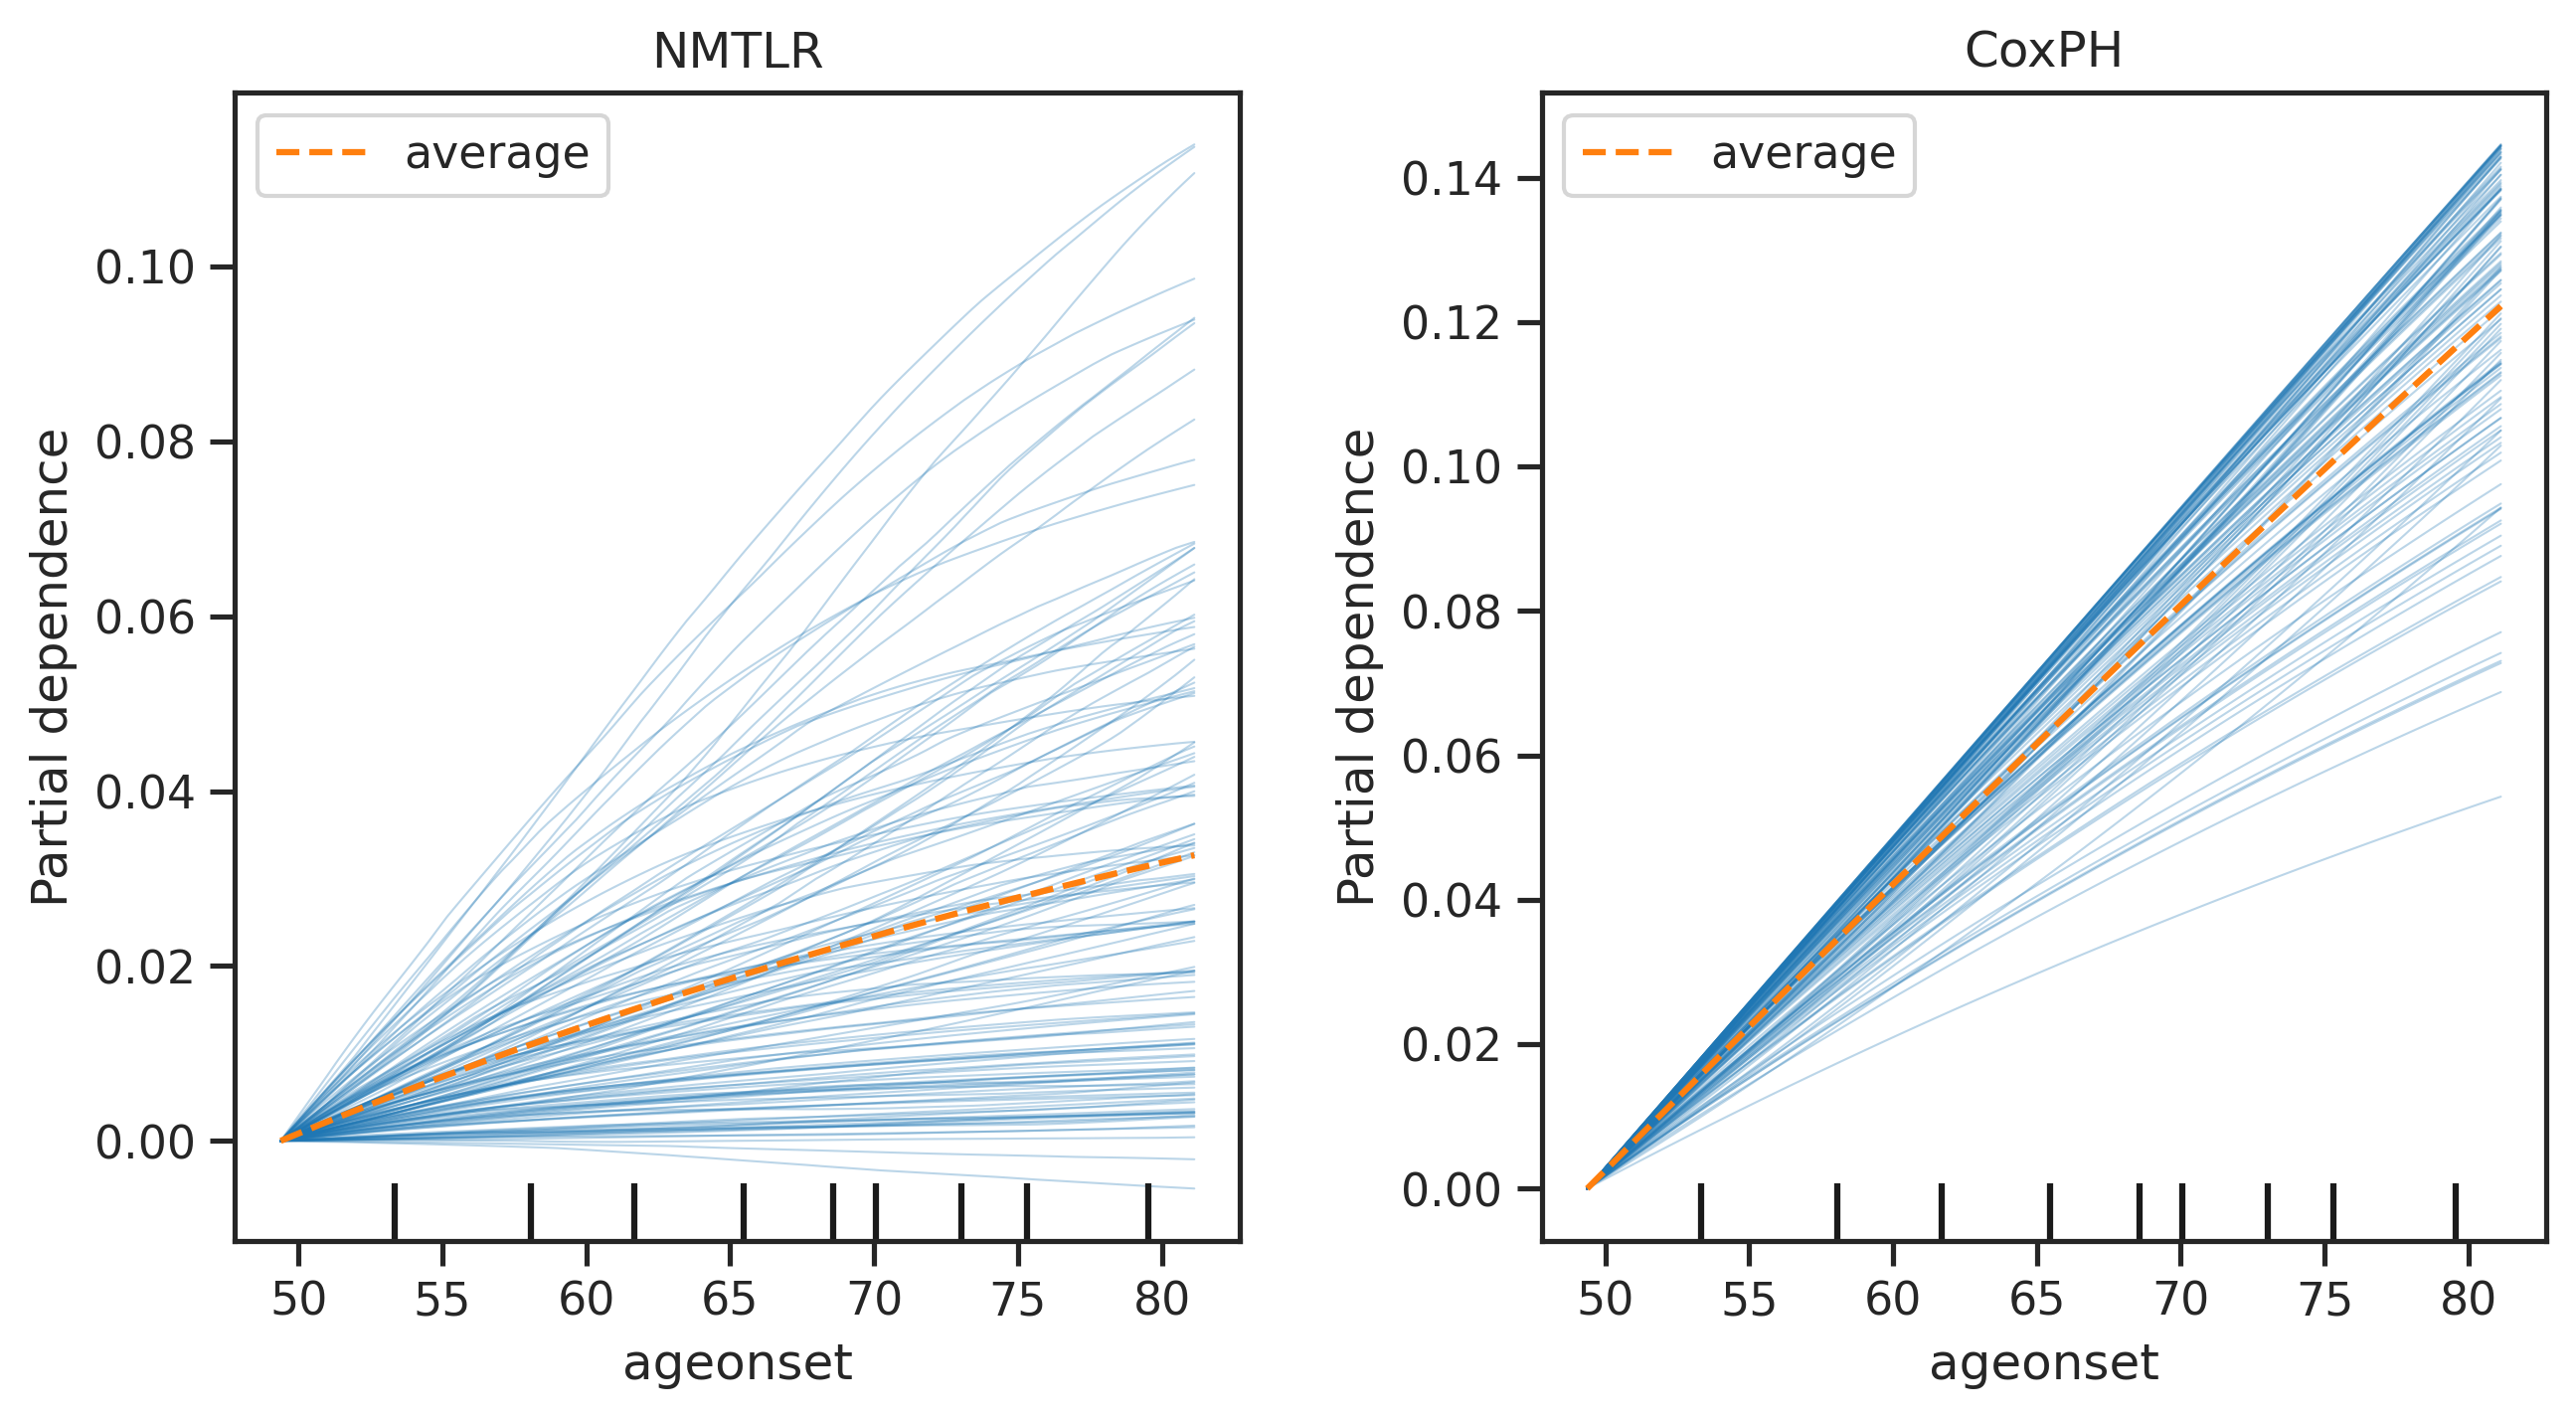

In [39]:
# Configure features to present
features_info = {
    'features': ['ageonset'],
    'kind': 'both',
    'centered': True,
}

# Configure subplots
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=300, sharey=True)
sns.set_theme(
    style='ticks',
    font='Arial'
)

# Get encoder and model
encoder, nmtlr_model = nmtlr_ensemble[mice_i][0], nmtlr_ensemble[mice_i][1]

# Encode X
X_test1 = encoder.transform(X_test)

display = PartialDependenceDisplay.from_estimator(
    nmtlr_model,
    X_test1,
    **features_info,
    ax=axes[0]
)
axes[0].set_title('NMTLR')

# Get encoder and model
encoder, coxph_model = coxph_ensemble[mice_i][0], coxph_ensemble[mice_i][1]

# Encode X
X_test2 = encoder.transform(X_test)

display = PartialDependenceDisplay.from_estimator(
    coxph_model,
    X_test2,
    **features_info,
    ax=axes[1]
)
axes[1].set_title('CoxPH')

# Fix spacing
plt.subplots_adjust(wspace=0.3)

# Continuous Feature Interactions

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Text(0.5, 1.0, 'CoxPH')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

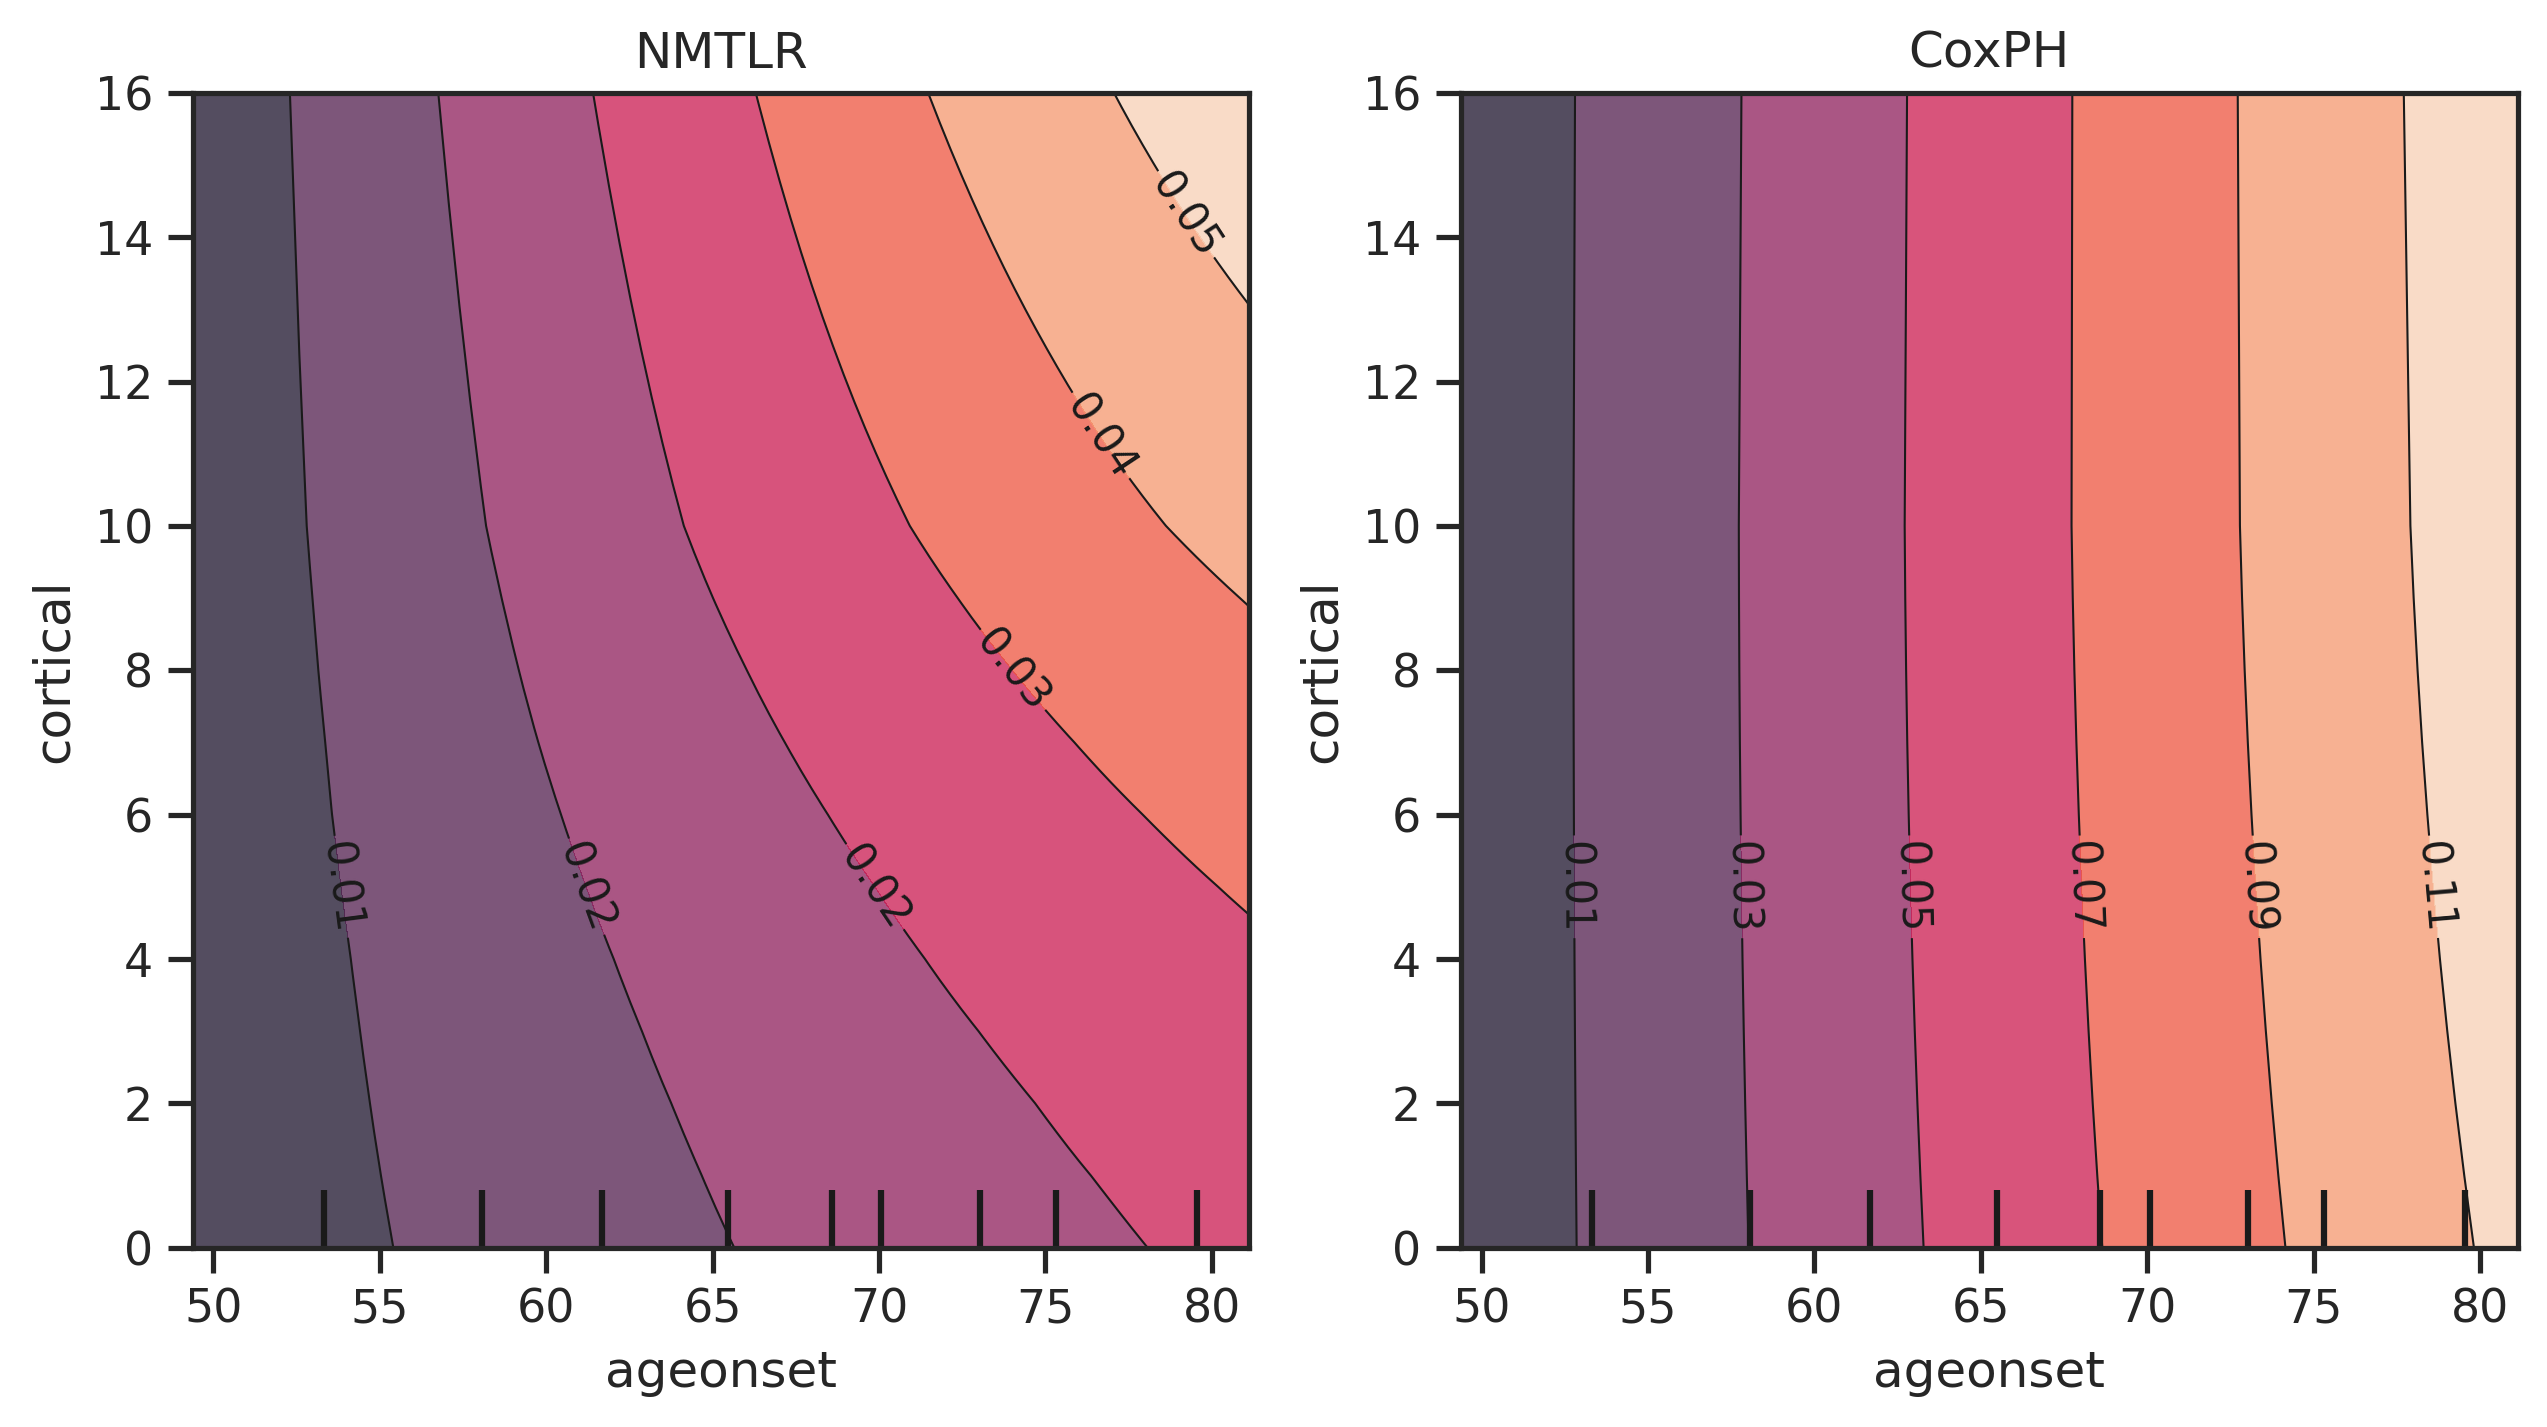

In [40]:
# Configure features to present
features_info = {
    'features': [('ageonset','cortical')],
    'kind': 'average',
    'centered': True,
}

# Configure subplots
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=300, sharey=True)
sns.set_theme(
    style='ticks',
    font='Arial'
)

# Get encoder and model
encoder, nmtlr_model = nmtlr_ensemble[mice_i][0], nmtlr_ensemble[mice_i][1]

# Encode X
X_test1 = encoder.transform(X_test)

display = PartialDependenceDisplay.from_estimator(
    nmtlr_model,
    X_test1,
    **features_info,
    ax=axes[0]
)
axes[0].set_title('NMTLR')

# Get encoder and model
encoder, coxph_model = coxph_ensemble[mice_i][0], coxph_ensemble[mice_i][1]

# Encode X
X_test1 = encoder.transform(X_test)

display = PartialDependenceDisplay.from_estimator(
    coxph_model,
    X_test1,
    **features_info,
    ax=axes[1]
)
axes[1].set_title('CoxPH')

### Continuous and Cateogrical Feature Interactions

NMTLR

In [41]:
cont_feat_name = 'ageonset'
features = [cont_feat_name]

# Get encoder and model
encoder, nmtlr_model = nmtlr_ensemble[mice_i][0], nmtlr_ensemble[mice_i][1]

# Encode X
X_test1 = encoder.transform(X_test)

# Calculate partial dependence
pd_ice = partial_dependence(nmtlr_model, X_test1, features, kind='both')
nmtlr_ice_df = pd.DataFrame(pd_ice['individual'][0], columns=pd_ice['values'][0])

# Centering
first_age = nmtlr_ice_df[nmtlr_ice_df.columns[0]]

for col in nmtlr_ice_df.columns:
    nmtlr_ice_df[col] = nmtlr_ice_df[col] - first_age

# Reset index and melt the DataFrame
nmtlr_ice_df = nmtlr_ice_df.reset_index()

cont_feat = nmtlr_ice_df.columns.to_list()
cont_feat.remove('index')

nmtlr_ice_df = nmtlr_ice_df.melt(
    id_vars='index',
    value_vars=cont_feat,
    var_name=cont_feat_name,
    value_name='partial_dependence'
)

# Add another data column for 2-way visualisation
new_data_name = 'thalamus'

new_data = X_test1[new_data_name]
new_data.reset_index(drop=True, inplace=True)

nmtlr_ice_df[new_data_name] = ''

for i, row in nmtlr_ice_df.iterrows():
    nmtlr_ice_df.loc[i, new_data_name] = new_data[row['index']]

/home/johnnytam/miniconda3/envs/scjdsurv/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


CoxPH

In [42]:
cont_feat_name = 'ageonset'
features = [cont_feat_name]

# Get encoder and model
encoder, coxph_model = coxph_ensemble[mice_i][0], coxph_ensemble[mice_i][1]

# Encode X
X_test1 = encoder.transform(X_test)

# Calculate partial dependence
pd_ice = partial_dependence(coxph_model, X_test1, features, kind='both')
coxph_ice_df = pd.DataFrame(pd_ice['individual'][0], columns=pd_ice['values'][0])

# Centering
first_age = coxph_ice_df[coxph_ice_df.columns[0]]

for col in coxph_ice_df.columns:
    coxph_ice_df[col] = coxph_ice_df[col] - first_age

# Reset index and melt the DataFrame
coxph_ice_df = coxph_ice_df.reset_index()

cont_feat = coxph_ice_df.columns.to_list()
cont_feat.remove('index')

coxph_ice_df = coxph_ice_df.melt(
    id_vars='index',
    value_vars=cont_feat,
    var_name=cont_feat_name,
    value_name='partial_dependence'
)

# Add another data column for 2-way visualisation
new_data_name = 'thalamus'

new_data = X_test1[new_data_name]
new_data.reset_index(drop=True, inplace=True)

coxph_ice_df[new_data_name] = ''

for i, row in coxph_ice_df.iterrows():
    coxph_ice_df.loc[i, new_data_name] = new_data[row['index']]

/home/johnnytam/miniconda3/envs/scjdsurv/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


Text(0.5, 1.0, 'CoxPH')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

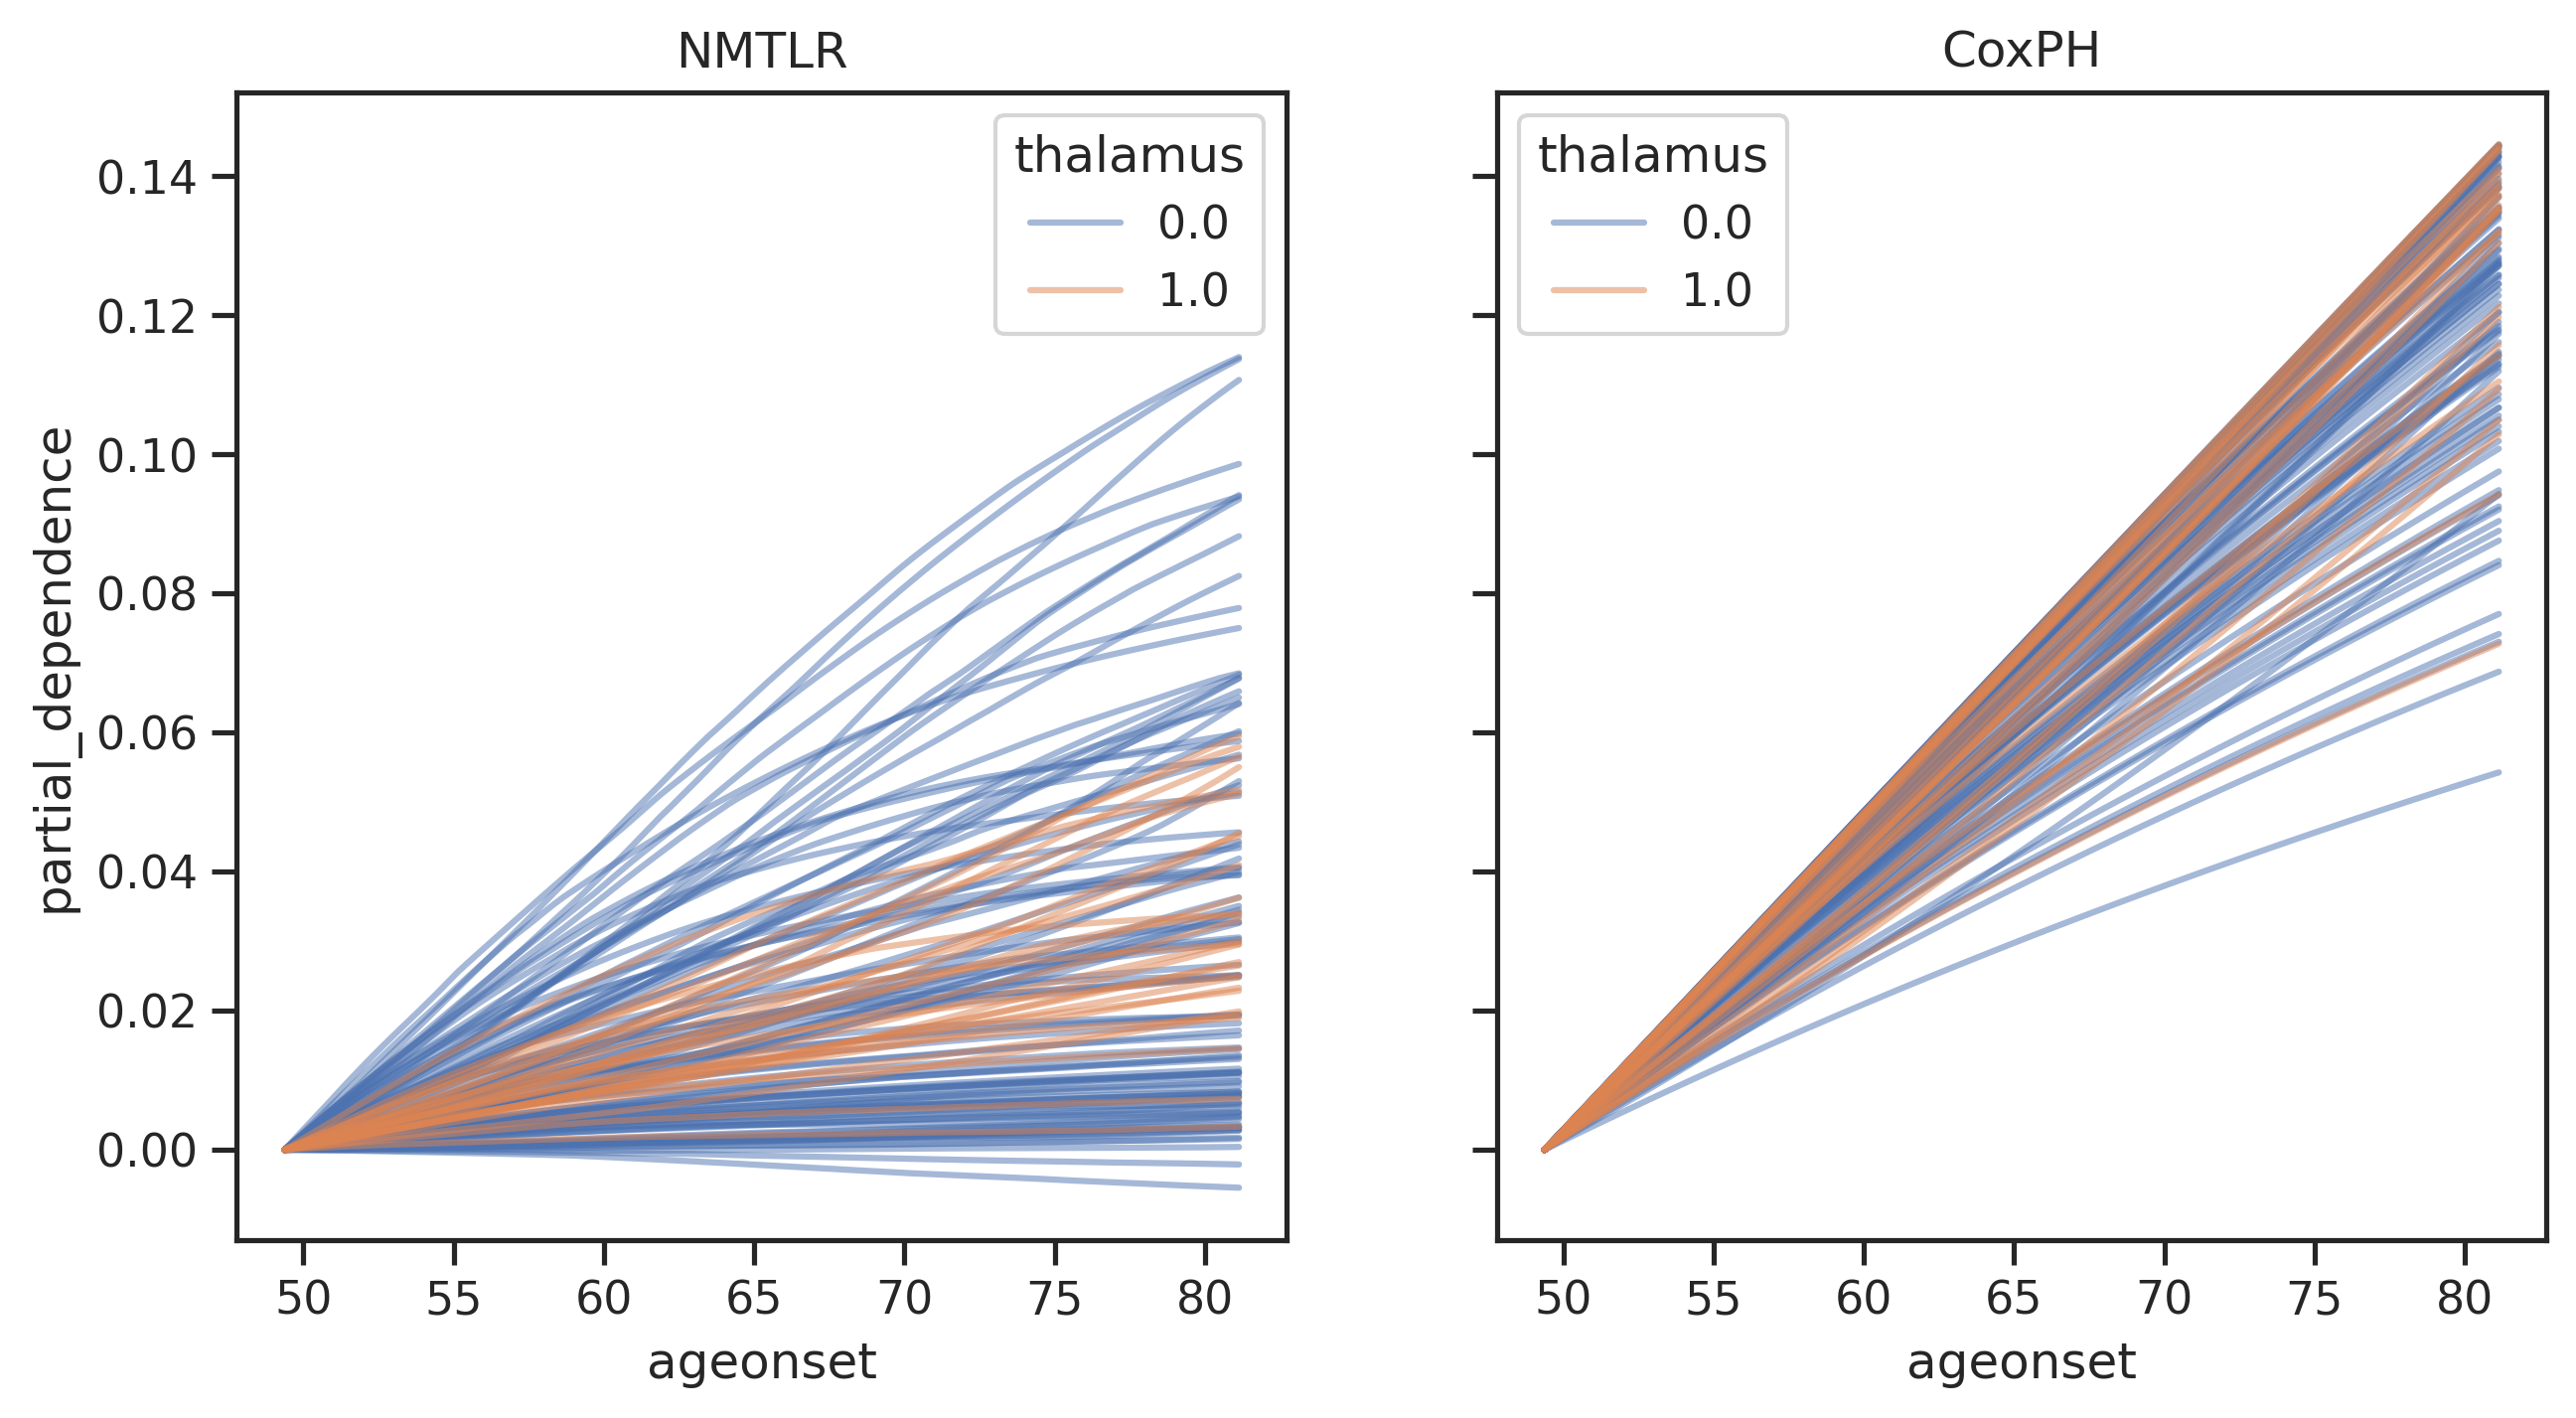

In [43]:
# Configure subplots
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=300, sharey=True)
sns.set_theme(
    style='ticks',
    font='Arial'
)

sns.lineplot(
    nmtlr_ice_df,
    x=cont_feat_name,
    y='partial_dependence',
    units='index',
    estimator=None,
    hue=new_data_name,
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title('NMTLR')

sns.lineplot(
    coxph_ice_df,
    x=cont_feat_name,
    y='partial_dependence',
    units='index',
    estimator=None,
    hue=new_data_name,
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title('CoxPH')
